<a href="https://colab.research.google.com/github/Maaulln/plant-detector/blob/main/plant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [86]:
!pip install kagglehub tensorflow matplotlib
!pip install scikit-learn

import kagglehub
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix


In [87]:
print("Downloading dataset from Kaggle...")
path = kagglehub.dataset_download("vbookshelf/rice-leaf-diseases")
print("Path to dataset files:", path)

# Cek isi folder dataset
print("\nIsi folder dataset:")
print(os.listdir(path))

Using Colab cache for faster access to the 'rice-leaf-diseases' dataset.
Path to dataset files: /kaggle/input/rice-leaf-diseases

Isi folder dataset:
['rice_leaf_diseases']


In [88]:
dataset_dir = os.path.join(path, "rice_leaf_diseases")
print("\nIsi folder dataset:")
print(os.listdir(dataset_dir))


Isi folder dataset:
['Brown spot', 'Bacterial leaf blight', 'Leaf smut']


In [89]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 80% train, 20% val
)

train_data = datagen.flow_from_directory(
    dataset_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_data = datagen.flow_from_directory(
    dataset_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 96 images belonging to 3 classes.
Found 24 images belonging to 3 classes.


In [90]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_data.num_classes, activation='softmax')
])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,027 (12.61 MB)

 Trainable params: 3,305,027 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [91]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [92]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=25,
    callbacks=[early_stop]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.2812 - loss: 1.1268 - val_accuracy: 0.3333 - val_loss: 1.0761
Epoch 2/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 928ms/step - accuracy: 0.3620 - loss: 1.0921 - val_accuracy: 0.3333 - val_loss: 1.1025
Epoch 3/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.3594 - loss: 1.1439 - val_accuracy: 0.3333 - val_loss: 1.1061
Epoch 4/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 925ms/step - accuracy: 0.4010 - loss: 1.0763 - val_accuracy: 0.5417 - val_loss: 1.0734
Epoch 5/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 952ms/step - accuracy: 0.3919 - loss: 1.0839 - val_accuracy: 0.3750 - val_loss: 1.0728
Epoch 6/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.3724 - loss: 1.0886 - val_accuracy: 0.5417 - val_loss: 1.0586
Epoch 7/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 948ms/step - accuracy: 0.3802 - loss: 1.0882 - val_accuracy: 0.5833 - val_loss: 1.0655
Epoch 8/25
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.4427 - loss: 1.0653 - val_accuracy: 0.4167 - val_loss: 1.0662
Epoc

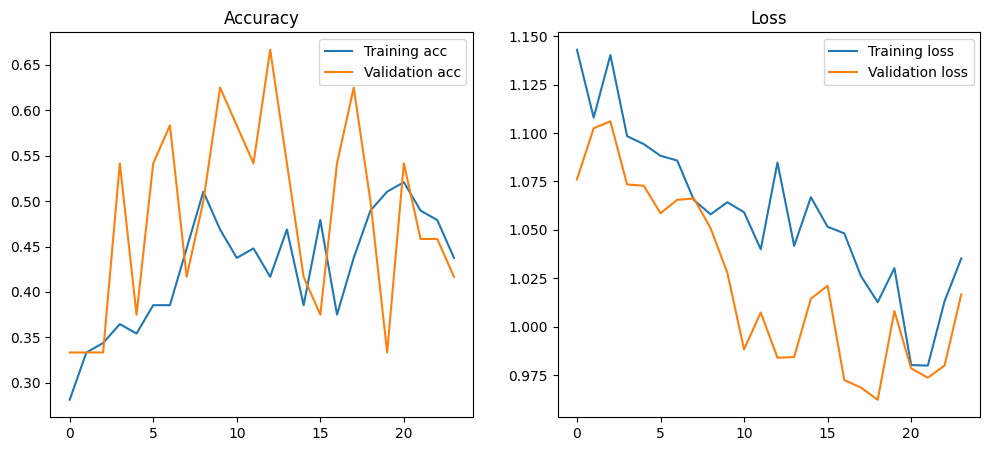

In [93]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Training acc')
plt.plot(history.history['val_accuracy'], label='Validation acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.title('Loss')
plt.show()

In [94]:
model.save('rice_disease_cnn_model.h5')
print("\nModel berhasil disimpan sebagai 'rice_disease_cnn_model.h5'")


Model berhasil disimpan sebagai 'rice_disease_cnn_model.h5'


In [95]:
print("\nEvaluasi model pada data validasi:")
val_data.reset()
preds = model.predict(val_data)
y_pred = np.argmax(preds, axis=1)
y_true = val_data.classes
class_names = list(val_data.class_indices.keys())

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))


Evaluasi model pada data validasi:


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step

Classification Report:
                       precision    recall  f1-score   support

Bacterial leaf blight       0.45      0.62      0.53         8
           Brown spot       0.88      0.88      0.88         8
            Leaf smut       0.40      0.25      0.31         8

             accuracy                           0.58        24
            macro avg       0.58      0.58      0.57        24
         weighted avg       0.58      0.58      0.57        24


Confusion Matrix:
[[5 1 2]
 [0 7 1]
 [6 0 2]]


In [96]:
from tensorflow.keras.preprocessing import image

def predict_image(img_path):
    img = image.load_img(img_path, target_size=(128, 128))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    predicted_class = class_names[np.argmax(prediction)]
    confidence = np.max(prediction) * 100

    print(f"Hasil Prediksi: {predicted_class} ({confidence:.2f}%)")

predict_image('/kaggle/input/rice-leaf-diseases/rice_leaf_diseases/Brown spot/DSC_0101.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Hasil Prediksi: Leaf smut (38.76%)


Saving trik_budidaya_padi.jpg to trik_budidaya_padi (2).jpg
Ukuran input model: (128, 128)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


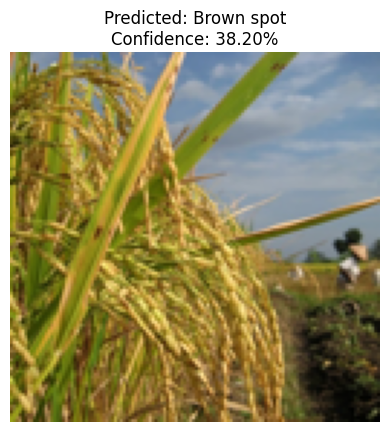

Gambar: trik_budidaya_padi (2).jpg
Prediksi: Brown spot
Tingkat keyakinan: 38.20%


In [97]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

uploaded = files.upload()

# Ambil ukuran input model otomatis
input_size = model.input_shape[1:3]
print(f"Ukuran input model: {input_size}")

for filename in uploaded.keys():
    try:
        img = Image.open(filename).convert("RGB")
        img = img.resize(input_size)  # otomatis sesuaikan dengan model
        img_array = np.array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        prediction = model.predict(img_array)
        predicted_class = class_names[np.argmax(prediction)]
        confidence = np.max(prediction) * 100

        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence:.2f}%", fontsize=12)
        plt.show()

        print(f"Gambar: {filename}")
        print(f"Prediksi: {predicted_class}")
        print(f"Tingkat keyakinan: {confidence:.2f}%")

    except Exception as e:
        print(f"Gagal memproses {filename}: {e}")
